[Using google's Lightweight MMM packag with channel/adstock tuning and exporting modelled response curves](https://colab.research.google.com/drive/1zKHmT_CR6AmVbH-4PdsmUJdumMadcmrO#scrollTo=WcYeesq4w3jT)

In [1]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro
import pandas as pd
import numpy as np
from jax.random import PRNGKey


# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

from sklearn.metrics import mean_absolute_percentage_error
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, init_to_value

from prjpkg import globalsettings as gs
from prjpkg.tools import adstock, hill

%load_ext autoreload
%autoreload 2


c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# https://github.com/google/lightweight_mmm/issues/136

from jax.config import config
config.update('jax_enable_x64', True)

# Data

## Creating Synthetic Media and external factors

In [3]:
SEED = 105
channel_names=['social','tv', 'sem', 'display', 'programmatic']

data_size = (52*3) + 26 # we'll be using 3 years of weekly data for trainingdata, and adding half a year as our test data
n_media_channels = len(channel_names)
n_extra_features = 5

In [4]:
media_data, extra_features, target, costs = utils.simulate_dummy_data(
    data_size        = data_size,
    n_media_channels = n_media_channels,
    n_extra_features = n_extra_features,
    seed = SEED)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
# Split and scale data.
split_point = data_size - 26

# Media data
media_data_train = media_data[:split_point, ...]
media_data_test  = media_data[split_point:, ...]

# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test  = extra_features[split_point:, ...]

# Target
target_train = target[:split_point]

## Scaling of data

In [6]:
media_scaler          = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler         = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler           = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train     = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train         = target_scaler.fit_transform(target_train)
costs                = cost_scaler.fit_transform(costs)

# Tuning

## beta_media

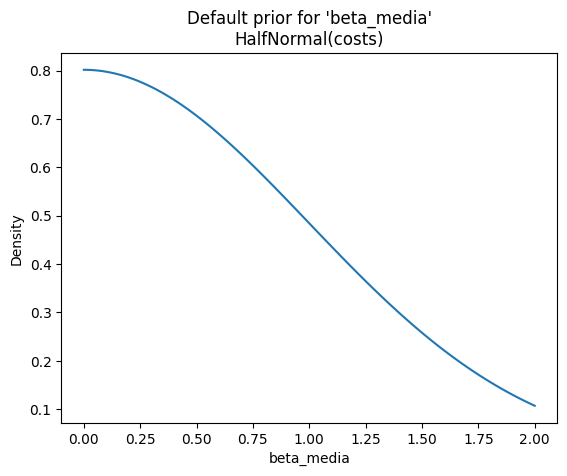

In [6]:
from numpyro import distributions as dist
import matplotlib.pyplot as plt
from jax.scipy.special import expit
from jax import lax, random

x = jnp.linspace(0, 2, 101)
plt.plot(x, jnp.exp(dist.HalfNormal(costs[0]).log_prob(x)))
plt.gca().set(xlabel="beta_media", ylabel="Density", 
              title = "Default prior for 'beta_media'\nHalfNormal(costs)")
plt.show()

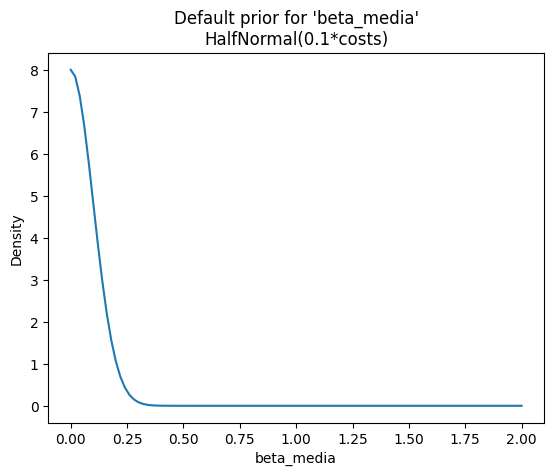

In [7]:
x = jnp.linspace(0, 2, 101)
plt.plot(x, jnp.exp(dist.HalfNormal(0.1*costs[0]).log_prob(x)))
plt.gca().set(xlabel="beta_media", ylabel="Density", 
              title = "Default prior for 'beta_media'\nHalfNormal(0.1*costs)")
plt.show()


## Adstock

 “lag_weight” Default prior: `numpyro.distributions.Beta(concentration1=2., concentration0=1.)`

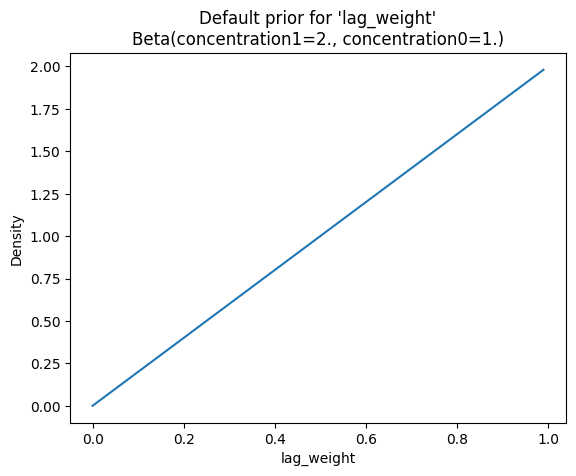

In [8]:
## Example of the adstock's probability density

x = jnp.linspace(0, 1, 101)
plt.plot(x, jnp.exp(dist.Beta(concentration1=2, concentration0=1.).log_prob(x)))
plt.gca().set(xlabel="lag_weight", ylabel="Density", 
              title = "Default prior for 'lag_weight'\nBeta(concentration1=2., concentration0=1.)")
plt.show()

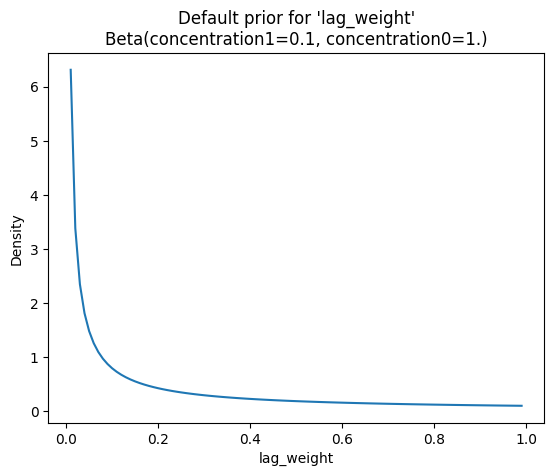

In [9]:
## here is the probability when trying to reduce the adstock's effect to be near 0

x = jnp.linspace(0, 1, 101)
plt.plot(x, jnp.exp(dist.Beta(concentration1=0.1, concentration0=1).log_prob(x)))
plt.gca().set(xlabel="lag_weight", ylabel="Density", 
              title = "Default prior for 'lag_weight'\nBeta(concentration1=0.1, concentration0=1.)")
plt.show()

## Hill

“half_max_effective_concentration” default prior: `numpyro.distributions.Gamma(concentration=1., rate=1.)`

“slope”: default prior: `numpyro.distributions.Gamma(concentration=1., rate=1.)`

In [7]:
# Esto es el prior predictive de beta_media, half_ell, slope y lag_weight con
# las priors por defecto

##randomkey to generate new coefficient sampling
key=PRNGKey(456)

test_media=jnp.linspace(0, 50, 1000)

cost=jnp.sum(test_media*0.15)

beta_media=numpyro.sample("beta_media", dist.HalfNormal(cost), rng_key=key)
half_eff  =numpyro.sample("half_eff",   dist.Gamma(concentration=1., rate=1.), rng_key=key)
lag       =numpyro.sample("lag",        dist.Beta(concentration1=1., concentration0=1.),rng_key=key)
slope_    =numpyro.sample("slope",      dist.Gamma(concentration=1., rate=1.), rng_key=key)

x=test_media
y=beta_media*hill(
    data=adstock(
        data=test_media.reshape(-1,1), lag_weight=lag, normalise=True),
    half_max_effective_concentration=half_eff,
    slope=slope_)

y_noise=(y+(np.random.normal(350, 900, len(x))).reshape(-1,1))+np.random.randint(0,6,len(x)).reshape(-1,1)
y_noise=y_noise.at[y_noise < 0].set(0)

plt.title("Hypothetical Sales Contribution from a channel")
plt.scatter(x,y_noise)
plt.xlabel("Channel Spend")
plt.ylabel("Channel Contribution")

NameError: name 'dist' is not defined

In [11]:
# Modelo numpyro con las priors por defecto - como las reales con las que
# se han generado los datos
def hill_model(x,cost,y):
    beta_media=numpyro.sample("beta_media", dist.HalfNormal(cost))
    half_eff  =numpyro.sample("half_eff",   dist.Gamma(concentration=1., rate=1.))
    lag       =numpyro.sample("lag",        dist.Beta(concentration1=1., concentration0=1.))
    slope_    =numpyro.sample("slope",      dist.Gamma(concentration=1., rate=1.))


    y_pred=numpyro.deterministic('y_pred',beta_media*hill(
            data=adstock(
                data=x.reshape(-1,1), lag_weight=lag, normalise=True),
            half_max_effective_concentration=half_eff,
            slope=slope_))
    mu = numpyro.deterministic(name="mu", value=y_pred)

    with numpyro.plate(name="sigma_plate", size=1):
        sigma = numpyro.sample(
            name="sigma",
            fn=dist.Gamma(concentration=1., rate=1.))

    numpyro.sample(
      name="target", fn=dist.Normal(loc=mu, scale=sigma), obs=y)

In [12]:
nuts_kernel = NUTS(hill_model, adapt_step_size=True)
mcmc        = MCMC(nuts_kernel, num_chains=1, num_warmup=100, num_samples=100)

rng_key=PRNGKey(12)
mcmc.run(rng_key, x=x, cost=cost, y=y_noise)

sample: 100%|██████████| 200/200 [00:19<00:00, 10.30it/s, 143 steps of size 5.39e-04. acc. prob=0.97] 


MAPE: 0.23025909066200256


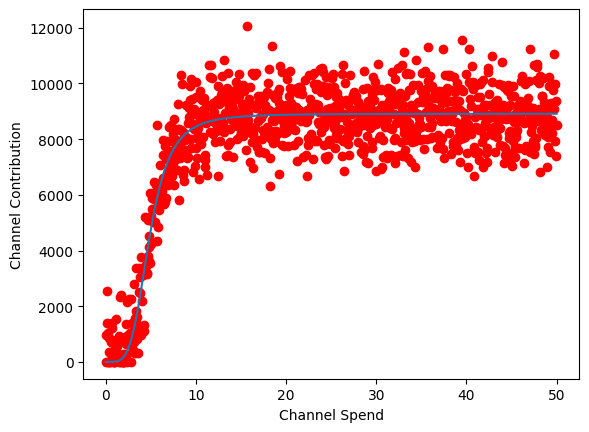

In [13]:
y_pred=mcmc.get_samples()['mu'].mean(axis=0)

plt.scatter(x,y_noise, color='red',label="y_true")
plt.xlabel("Channel Spend")
plt.ylabel("Channel Contribution")
plt.plot(x,y_pred, label='y_pred')

print(f"MAPE: {mean_absolute_percentage_error(y,y_pred)}")

In [14]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  beta_media   8914.30     27.94   8913.91   8854.17   8949.55    105.22      1.01
    half_eff      2.84      1.48      2.38      1.19      4.62      2.43      4.20
         lag      0.94      0.06      0.98      0.84      1.00      2.87      2.27
    sigma[0]    700.12     12.69    700.09    680.34    720.18    107.21      0.99
       slope      3.03      0.72      2.73      2.16      3.99      2.49      3.59

Number of divergences: 0


El segundo modelo va a tener otras priors, intentando reducir el lag_weight y
K y S

In [15]:
## Note: we are using different concetrations
## In this case, we are reducing adstock as well as the diminishing point and slop of the curve

def hill_model2(x,cost,y):
    beta_media=numpyro.sample("beta_media", dist.HalfNormal(cost*0.1))
    half_eff  =numpyro.sample("half_eff",   dist.Gamma(concentration=0.1, rate=1.))
    lag       =numpyro.sample("lag",        dist.Beta(concentration1=0.1, concentration0=1.))
    slope_    =numpyro.sample("slope",      dist.Gamma(concentration=0.1, rate=1.))


    y_pred=numpyro.deterministic('y_pred',beta_media*hill(
            data=adstock(
                data=x.reshape(-1,1), lag_weight=lag, normalise=True),
            half_max_effective_concentration=half_eff,
            slope=slope_))
    mu = numpyro.deterministic(name="mu", value=y_pred)

    with numpyro.plate(name="sigma_plate", size=1):
        sigma = numpyro.sample(
            name="sigma",
            fn=dist.Gamma(concentration=1., rate=1.))

    numpyro.sample(
      name="target", fn=dist.Normal(loc=mu, scale=sigma), obs=y)

In [16]:
nuts_kernel = NUTS(hill_model2, adapt_step_size=True)
mcmc2       = MCMC(nuts_kernel, num_chains=1, num_warmup=200, num_samples=200)

rng_key     = PRNGKey(12)
mcmc2.run(rng_key, x=x, cost=cost, y=y_noise)

sample: 100%|██████████| 400/400 [00:14<00:00, 27.24it/s, 15 steps of size 2.59e-01. acc. prob=0.86] 


MAPE: 0.42820143699645996


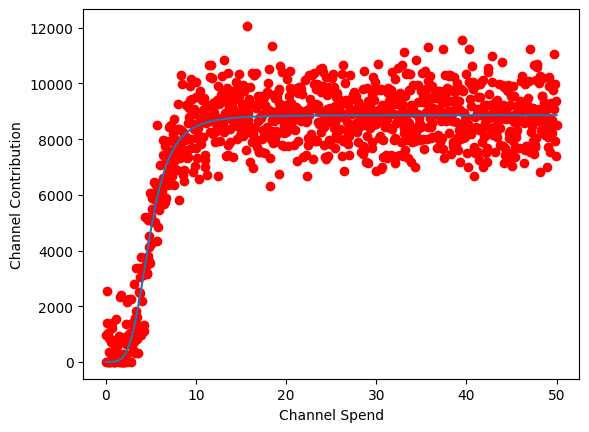

In [17]:
y_pred2=mcmc2.get_samples()['mu'].mean(axis=0)

plt.scatter(x,y_noise, color='red',label="y_true")
plt.xlabel("Channel Spend")
plt.ylabel("Channel Contribution")
plt.plot(x,y_pred2.squeeze(), label='y_pred')
print(f"MAPE: {mean_absolute_percentage_error(y,y_pred2)}")

In [18]:
mcmc2.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  beta_media   8861.00     24.48   8861.06   8829.68   8906.34    263.13      1.00
    half_eff      4.84      0.05      4.84      4.77      4.93    133.76      1.00
         lag      0.05      0.12      0.00      0.00      0.20    123.89      1.01
    sigma[0]    703.67     11.78    703.03    685.90    723.19    128.24      1.00
       slope      4.19      0.15      4.20      3.94      4.41    113.21      1.00

Number of divergences: 6


+ `beta_media` ha bajado mínimamente, de 8866.27 a 8824.22
+ `lag_weight`: ha **bajado considerablemente**, de 0.74 a 0.03
+ $K$ (`half_eff`): ha **subido**, de 3.95 a 4.86
+ $S$ (`slope`): ha **subido**, de 3.68 a 4.34

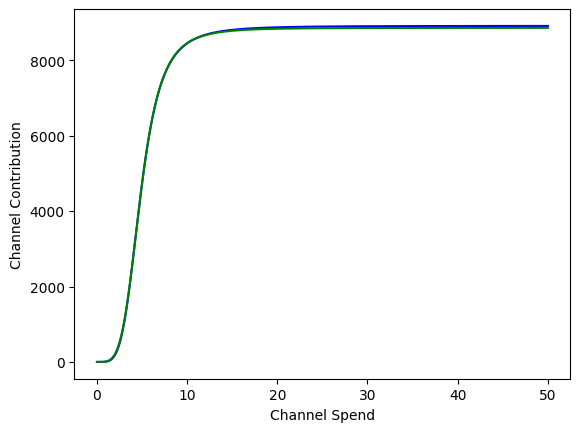

In [19]:
# plt.scatter(x,y_noise, color='red',label="y_true")
plt.xlabel("Channel Spend")
plt.ylabel("Channel Contribution")
plt.plot(x,y_pred.squeeze(),  label='y_pred', color = "blue")
plt.plot(x,y_pred2.squeeze(), label='y_pred', color = "green")

# Models

In [11]:
# See detailed explanation on custom priors in our documentation. https://lightweight-mmm.readthedocs.io/en/latest/custom_priors.html
# trailing setting custom concentration weights for half effective concentration

# PARA LAS BETA_MEDIA
channel_contribution_weights={
    'social':       1.,
    'tv':           0.5,
    'sem':          1.,
    'display':      1.,
    'programmatic': 1.
    }
mod_media_priors=jnp.array(list(channel_contribution_weights.values()))*costs

# PARA LOS LAG_WEIGHTS
channel_adstock_weights={
    'social':       2.,
    'tv':           2.,
    'sem':          0.01, ## It is commonly assumed that SEM has little to no adstock decay in the industry due to user browsing habits. The default beta is 2
    'display':      2.,
    'programmatic': 2.
    }
adstock_lag_weight_priors=jnp.array(list(channel_adstock_weights.values()))

# PARA LAS K (HALF_EFF)
media_concentration_weights={
    'social':       1.,
    'tv':           0.8,
    'sem':          0.5,
    'display':      1.,
    'programmatic': 1.
    }

media_concentration_weights_priors=jnp.array(list(media_concentration_weights.values()))

custom_priors = {
    "lag_weight": numpyro.distributions.Beta(concentration1 = adstock_lag_weight_priors, 
                                             concentration0 = jnp.ones(len(adstock_lag_weight_priors))),
    "half_max_effective_concentration": numpyro.distributions.Gamma(concentration = media_concentration_weights_priors, 
                                                                    rate          = jnp.ones(len(media_concentration_weights_priors),))
                 }

In [12]:
# Fit model.

mmm = lightweight_mmm.LightweightMMM(
    model_name         = "hill_adstock")

mmm.fit(media          = media_data_train,
        extra_features = extra_features_train,
        media_prior    = mod_media_priors,
        target         = target_train,
        number_warmup  = 1000,
        number_samples = 1000,
        number_chains  = 2,
        custom_priors  = custom_priors
        )

c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\lightweight_mmm\lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 2000/2000 [06:37<00:00,  5.03it/s, 1023 steps of size 2.93e-03. acc. prob=0.96]


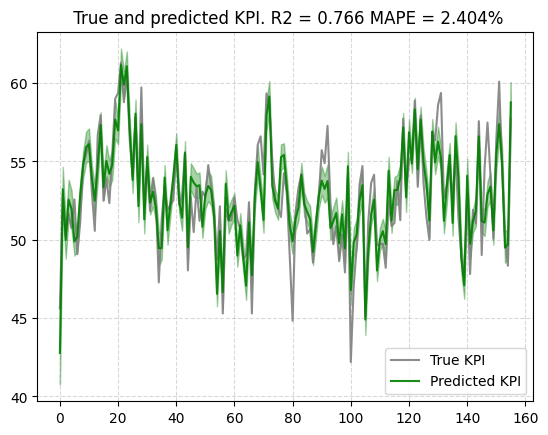

In [13]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

In [14]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

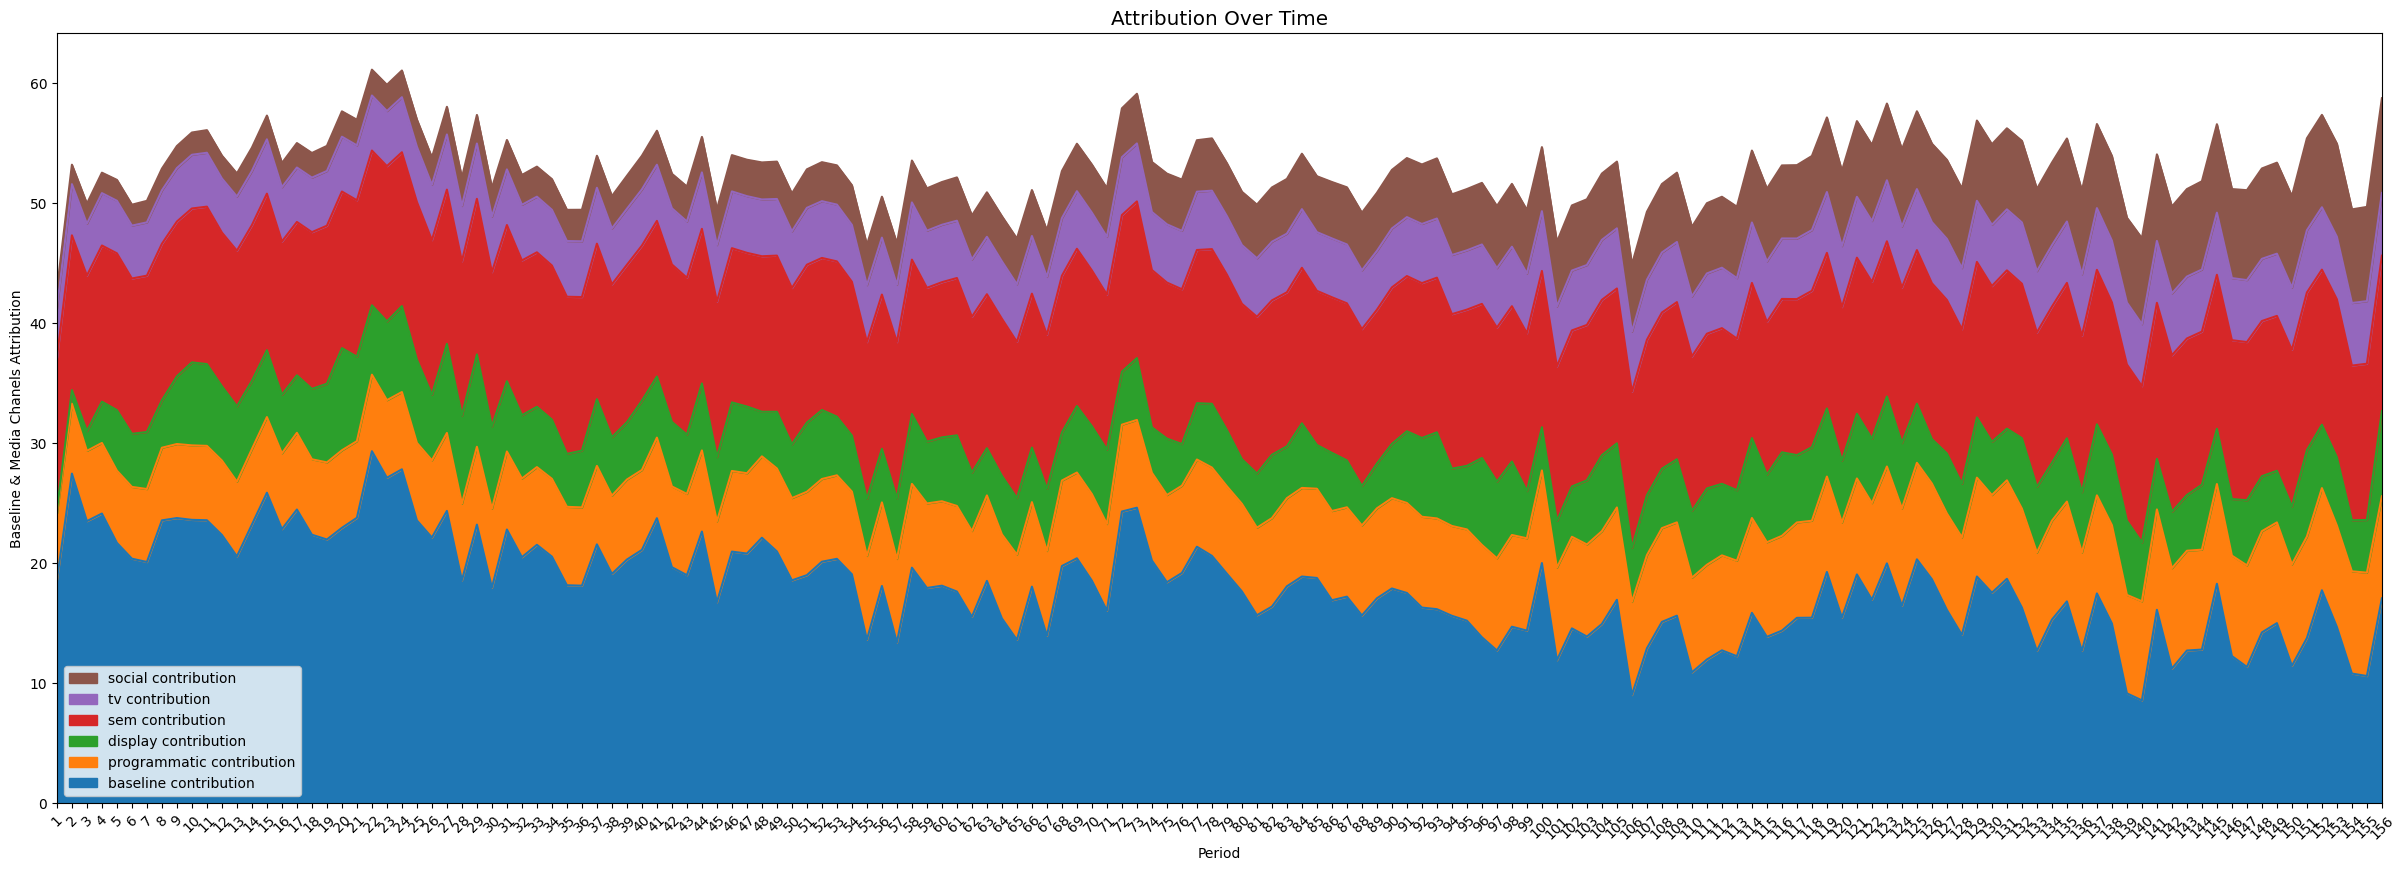

In [15]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model = mmm,
                                                target_scaler   = target_scaler,
                                                channel_names   = channel_names,
                                                fig_size        = (30,10))

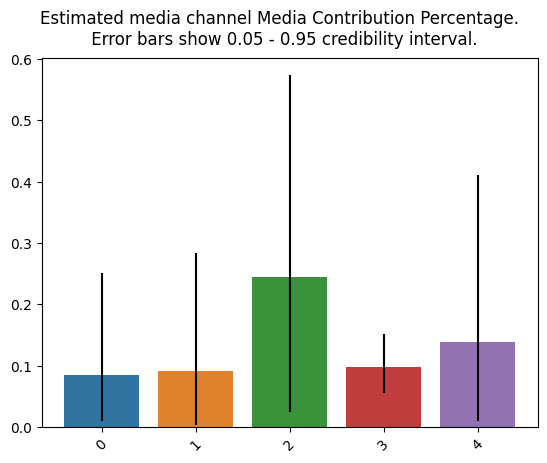

In [16]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage")

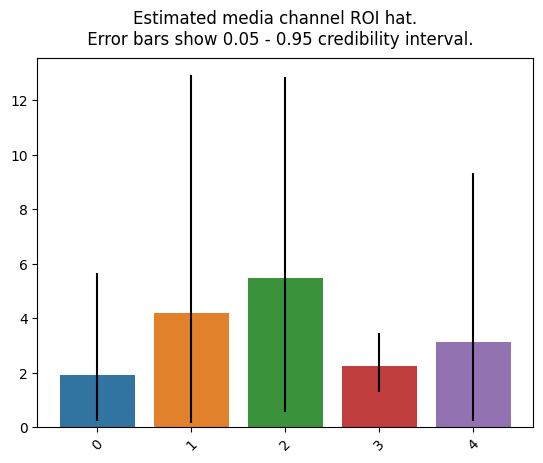

In [17]:

plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat")

In [18]:
pd.DataFrame({'channels':channel_names, 'adstock_decay':mmm.trace['lag_weight'].mean(axis=0)})

,channels,adstock_decay
0,social,0.884271
1,tv,0.698076
2,sem,0.005120
3,display,0.542642
4,programmatic,0.655337


In [20]:
utils.save_model(media_mix_model=mmm, file_path="../../outputs/files/mmm_2")

In [21]:
# Once saved one can load the models.
loaded_mmm = utils.load_model(file_path="../../outputs/files/mmm_2")
loaded_mmm.trace["coef_media"].shape # Example of accessing any of the model values.

(2000, 5)